### Compares Fe, Phyto nut lims, and NPP between two simulations (with and without the BC Fe bug fix)
#### (Uses one year of monthly history files)

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
from statistics import mean
from matplotlib import style
from scipy import stats
style.use('ggplot')

import matplotlib.colors as colors

In [2]:
user='kristenk'
cases=['g.e21.G1850ECOIAF.T62_g16.001', 'g.e21.G1850ECOIAF.T62_g16.002']
year_to_compare=10
path1=['/glade/scratch/kristenk/archive/' + cases[0] + '/ocn/hist/']
path2=['/glade/scratch/kristenk/archive/' + cases[1] + '/ocn/hist/']

### Get case 1 (no bug fix)

In [3]:
files = []
yr4="{:04d}".format(year_to_compare)
print('doing simulation year', year_to_compare, '!')
for month in range(1, 13):
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/scratch/{user}/archive/{cases[0]}/ocn/hist/{cases[0]}.pop.h.{yr4}-{mo2}.nc')))
#print(files)

doing simulation year 10 !


In [4]:
ds1=xr.open_mfdataset(files,decode_times=False,decode_coords=False, concat_dim='time')

In [5]:
#ds1

### Get case 2 (with bug fix)

In [6]:
files = []
yr4="{:04d}".format(year_to_compare)
print('doing simulation year', year_to_compare, '!')
for month in range(1, 13):
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/scratch/{user}/archive/{cases[1]}/ocn/hist/{cases[1]}.pop.h.{yr4}-{mo2}.nc')))
#print(files)

doing simulation year 10 !


In [7]:
ds2=xr.open_mfdataset(files,decode_times=False,decode_coords=False, concat_dim='time')

### Just keep the variables we need

In [8]:
variables = ['NO3', 'PO4', 'SiO3','AOU','O2','Fe','IRON_FLUX','sp_Fe_lim_surf','sp_P_lim_surf','sp_N_lim_surf',
             'diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf','diat_SiO3_lim_surf','diaz_P_lim_surf',
             'diaz_Fe_lim_surf','photoC_TOT_zint','photoC_sp_zint','photoC_diat_zint','photoC_diaz_zint']
coords = {'x':'TLONG','y':'TLAT'}
keepthese = ['z_t','z_t_150m','time_bound','TAREA','REGION_MASK', 'time']
keep_vars = keepthese + variables + list(coords.values())+['dz','KMT']
ds1 = ds1.drop([v for v in ds1.variables if v not in keep_vars])
ds2 = ds2.drop([v for v in ds2.variables if v not in keep_vars])

In [9]:
#ds1

In [10]:
ds1_annmean = ds1.mean(dim='time')
ds2_annmean = ds2.mean(dim='time')

In [11]:
NO3_diff = ds2_annmean.NO3 - ds1_annmean.NO3
PO4_diff = ds2_annmean.PO4 - ds1_annmean.PO4
SiO3_diff = ds2_annmean.SiO3 - ds1_annmean.SiO3
AOU_diff = ds2_annmean.AOU - ds1_annmean.AOU
O2_diff = ds2_annmean.O2 - ds1_annmean.O2
Fe_diff = ds2_annmean.Fe - ds1_annmean.Fe
IRON_FLUX_DIFF = ds2_annmean.IRON_FLUX - ds1_annmean.IRON_FLUX

In [12]:
#just getting this for the coords (that don't have nans)
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA_POPgrid.nc'
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
z_t = ds1.z_t

In [13]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01

### Make maps of Fe and IRON_FLUX

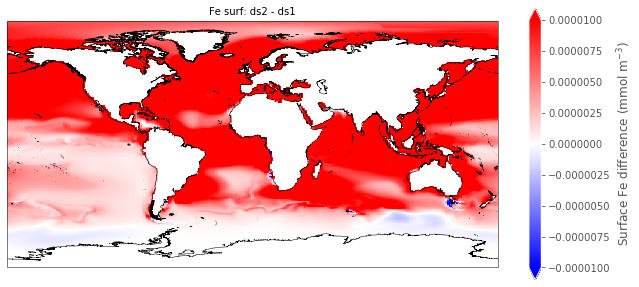

In [30]:
fig = plt.figure(figsize=(11,5))

#---- CESM panel
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('Fe surf: ds2 - ds1', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 Fe_diff.isel(z_t=0), vmin=-0.00001, vmax=0.00001, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='both',label='Surface Fe difference (mmol m$^{-3}$)')

In [15]:
ds1_annmean.IRON_FLUX

<xarray.DataArray 'IRON_FLUX' (nlat: 384, nlon: 320)>
dask.array<mean_agg-aggregate, shape=(384, 320), dtype=float32, chunksize=(384, 320), chunktype=numpy.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Atmospheric Iron Flux
    units:         mmol/m^2/s
    coordinates:   TLONG TLAT time
    grid_loc:      2110
    cell_methods:  time: mean

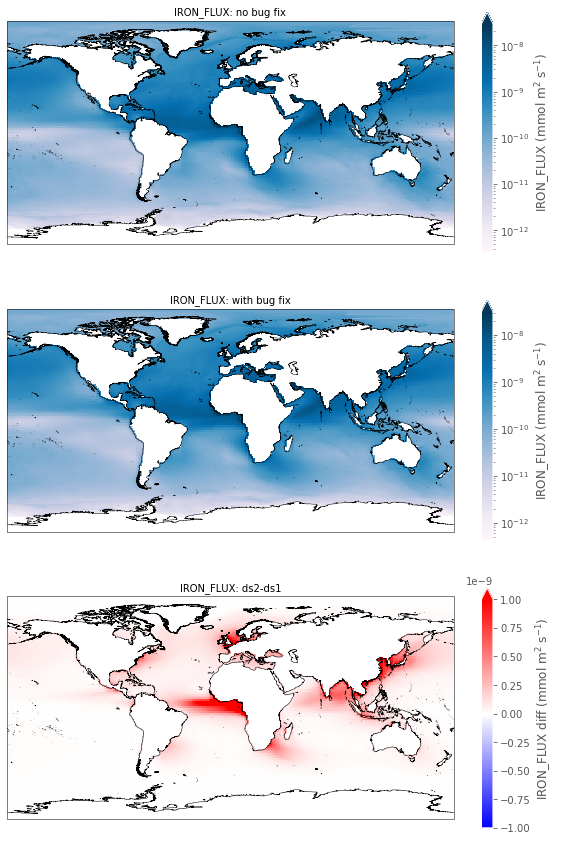

In [16]:
fig = plt.figure(figsize=(10,15))

#---- CESM panel
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('IRON_FLUX: no bug fix', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds1_annmean.IRON_FLUX, cmap='PuBu',
                norm=colors.LogNorm(),
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='IRON_FLUX (mmol m$^2$ s$^{-1}$)')

#---- CESM panel
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('IRON_FLUX: with bug fix', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds2_annmean.IRON_FLUX, cmap='PuBu',
                norm=colors.LogNorm(),
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='IRON_FLUX (mmol m$^2$ s$^{-1}$)')

#---- CESM panel
ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('IRON_FLUX: ds2-ds1', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds2_annmean.IRON_FLUX-ds1_annmean.IRON_FLUX, cmap='bwr',
                  vmin=-1e-9, vmax=1e-9,
                #norm=colors.LogNorm(),
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='IRON_FLUX diff (mmol m$^2$ s$^{-1}$)')

### Phytoplankton nutrient limitation at surface maps

In [17]:
from matplotlib.colors import LinearSegmentedColormap
def discrete_cmap(levels, base_cmap):
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, levels))
    cmap_name = base.name + str(levels)
    return LinearSegmentedColormap.from_list(cmap_name, color_list, levels)

In [18]:
#most limiting nutrient
# 0 = NO3
# 1 = PO4
# 2 = Fe
# 3 = Si (only for diat)

ds1_limarray_sp=xr.concat((ds1_annmean.sp_N_lim_surf, ds1_annmean.sp_P_lim_surf, ds1_annmean.sp_Fe_lim_surf),dim='nutrient')
ds1_limarray_diat=xr.concat((ds1_annmean.diat_N_lim_surf, ds1_annmean.diat_P_lim_surf, ds1_annmean.diat_Fe_lim_surf, ds1_annmean.diat_SiO3_lim_surf),dim='nutrient')
ds1_limarray_diaz=xr.concat((ds1_annmean.diaz_P_lim_surf, ds1_annmean.diaz_Fe_lim_surf),dim='nutrient')
ds2_limarray_sp=xr.concat((ds2_annmean.sp_N_lim_surf, ds2_annmean.sp_P_lim_surf, ds2_annmean.sp_Fe_lim_surf),dim='nutrient')
ds2_limarray_diat=xr.concat((ds2_annmean.diat_N_lim_surf, ds2_annmean.diat_P_lim_surf, ds2_annmean.diat_Fe_lim_surf, ds1_annmean.diat_SiO3_lim_surf),dim='nutrient')
ds2_limarray_diaz=xr.concat((ds2_annmean.diaz_P_lim_surf, ds2_annmean.diaz_Fe_lim_surf),dim='nutrient')

In [19]:
ds1_most_lim_sp=ds1_limarray_sp.argmin(dim='nutrient', skipna=False)
ds1_most_lim_diat=ds1_limarray_diat.argmin(dim='nutrient', skipna=False)
ds1_most_lim_diaz=ds1_limarray_diaz.argmin(dim='nutrient', skipna=False)
ds2_most_lim_sp=ds2_limarray_sp.argmin(dim='nutrient', skipna=False)
ds2_most_lim_diat=ds2_limarray_diat.argmin(dim='nutrient', skipna=False)
ds2_most_lim_diaz=ds2_limarray_diaz.argmin(dim='nutrient', skipna=False)

In [20]:
mask = np.isnan(ds1_annmean.sp_N_lim_surf.squeeze())

In [21]:
ds1_most_lim_sp = ds1_most_lim_sp.squeeze()
ds1_most_lim_diat = ds1_most_lim_diat.squeeze()
ds1_most_lim_diaz = ds1_most_lim_diaz.squeeze()
ds2_most_lim_sp = ds2_most_lim_sp.squeeze()
ds2_most_lim_diat = ds2_most_lim_diat.squeeze()
ds2_most_lim_diaz = ds2_most_lim_diaz.squeeze()

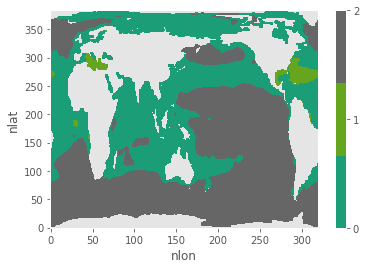

In [22]:
# TEST MAP
p = ds1_most_lim_sp.where(~mask).plot(cmap=discrete_cmap(3, plt.cm.Dark2), add_colorbar=False)
cb = plt.colorbar(p, orientation='vertical')
cb.set_ticks([0, 1, 2])
# 2 = Fe limited
# 1 = PO4 limited
# 0 = NO3 limited

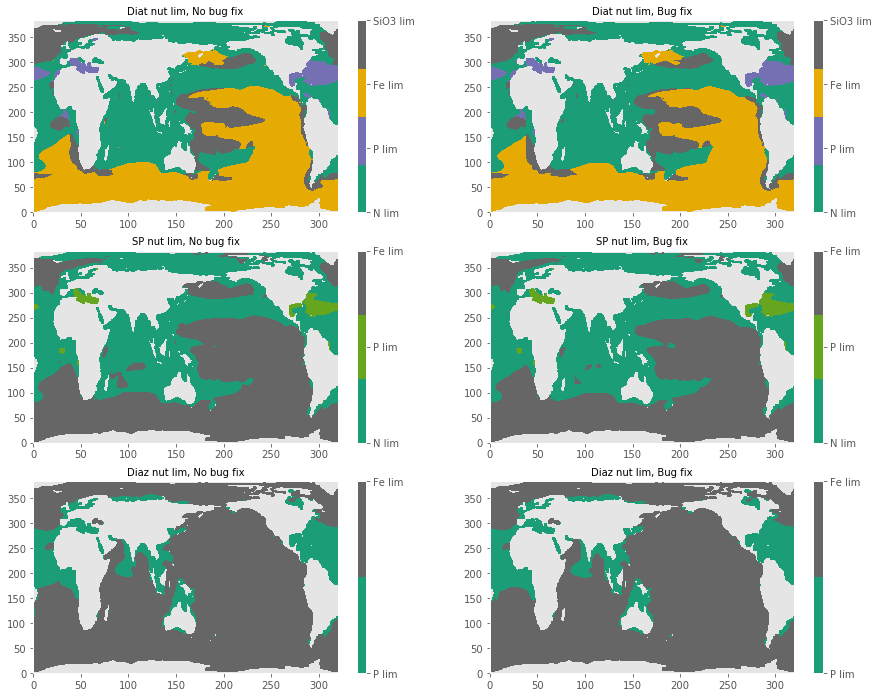

In [23]:
fig = plt.figure(figsize=(15,12))

ax = fig.add_subplot(3,2,1) #, projection=ccrs.PlateCarree())
ax.set_title('Diat nut lim, No bug fix', fontsize=10)
pc=ax.pcolormesh(ds1_most_lim_diat.where(~mask), cmap=discrete_cmap(4, plt.cm.Dark2)) #cmap=plt.cm.get_cmap('Dark2_r',6),vmin=0.5,vmax=6.5)
colorbar_specs = {'ticks' : np.arange(0,4,1)}
cbar = fig.colorbar(pc, ax=ax,**colorbar_specs)
cbar.ax.set_yticklabels(['N lim', 'P lim', 'Fe lim','SiO3 lim'])

ax = fig.add_subplot(3,2,2) #, projection=ccrs.PlateCarree())
ax.set_title('Diat nut lim, Bug fix', fontsize=10)
pc=ax.pcolormesh(ds2_most_lim_diat.where(~mask), cmap=discrete_cmap(4, plt.cm.Dark2)) #cmap=plt.cm.get_cmap('Dark2_r',6),vmin=0.5,vmax=6.5)
colorbar_specs = {'ticks' : np.arange(0,4,1)}
cbar = fig.colorbar(pc, ax=ax,**colorbar_specs)
cbar.ax.set_yticklabels(['N lim', 'P lim', 'Fe lim','SiO3 lim'])

ax = fig.add_subplot(3,2,3) #, projection=ccrs.PlateCarree())
ax.set_title('SP nut lim, No bug fix', fontsize=10)
pc=ax.pcolormesh(ds1_most_lim_sp.where(~mask), cmap=discrete_cmap(3, plt.cm.Dark2))
colorbar_specs = {'ticks' : np.arange(0,3,1)}
cbar = fig.colorbar(pc, ax=ax,**colorbar_specs)
cbar.ax.set_yticklabels(['N lim', 'P lim', 'Fe lim'])

ax = fig.add_subplot(3,2,4) #, projection=ccrs.PlateCarree())
ax.set_title('SP nut lim, Bug fix', fontsize=10)
pc=ax.pcolormesh(ds2_most_lim_sp.where(~mask), cmap=discrete_cmap(3, plt.cm.Dark2))
colorbar_specs = {'ticks' : np.arange(0,3,1)}
cbar = fig.colorbar(pc, ax=ax,**colorbar_specs)
cbar.ax.set_yticklabels(['N lim', 'P lim', 'Fe lim'])

ax = fig.add_subplot(3,2,5) #, projection=ccrs.PlateCarree())
ax.set_title('Diaz nut lim, No bug fix', fontsize=10)
pc=ax.pcolormesh(ds1_most_lim_diaz.where(~mask), cmap=discrete_cmap(2, plt.cm.Dark2))
colorbar_specs = {'ticks' : np.arange(0,2,1)}
cbar = fig.colorbar(pc, ax=ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim'])

ax = fig.add_subplot(3,2,6) #, projection=ccrs.PlateCarree())
ax.set_title('Diaz nut lim, Bug fix', fontsize=10)
pc=ax.pcolormesh(ds2_most_lim_diaz.where(~mask), cmap=discrete_cmap(2, plt.cm.Dark2))
colorbar_specs = {'ticks' : np.arange(0,2,1)}
cbar = fig.colorbar(pc, ax=ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim']);

### Net Primary Production

In [24]:
nmols_to_Pgyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

In [25]:
ds1_annmean['photoC_diat_zint']

<xarray.DataArray 'photoC_diat_zint' (nlat: 384, nlon: 320)>
dask.array<mean_agg-aggregate, shape=(384, 320), dtype=float32, chunksize=(384, 320), chunktype=numpy.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Diatom C Fixation Vertical Integral
    units:         mmol/m^3 cm/s
    coordinates:   TLONG TLAT time
    grid_loc:      2110
    cell_methods:  time: mean

In [26]:
variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'TOT']]

ds1_glb = xr.Dataset()
for v in variables:
    ds1_glb[v] = esmlab.statistics.weighted_sum(ds1_annmean[v], weights=area, dim=['nlat', 'nlon'])
    ds1_glb[v].attrs = ds1_annmean[v].attrs

    #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
    ds1_glb[v] = ds1_glb[v] * nmols_to_Pgyr        
    ds1_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds1_glb = ds1_glb.compute()
ds1_glb

<xarray.Dataset>
Dimensions:           ()
Data variables:
    photoC_diat_zint  float64 15.73
    photoC_sp_zint    float64 31.67
    photoC_diaz_zint  float64 1.601
    photoC_TOT_zint   float64 48.99

In [27]:
variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'TOT']]

ds2_glb = xr.Dataset()
for v in variables:
    ds2_glb[v] = esmlab.statistics.weighted_sum(ds2_annmean[v], weights=area, dim=['nlat', 'nlon'])
    ds2_glb[v].attrs = ds2_annmean[v].attrs

    #if ds2_annmean[v].units == 'mmol/m^3 cm/s':
    ds2_glb[v] = ds2_glb[v] * nmols_to_Pgyr        
    ds2_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

ds2_glb = ds2_glb.compute()
ds2_glb

<xarray.Dataset>
Dimensions:           ()
Data variables:
    photoC_diat_zint  float64 15.95
    photoC_sp_zint    float64 31.76
    photoC_diaz_zint  float64 1.628
    photoC_TOT_zint   float64 49.33

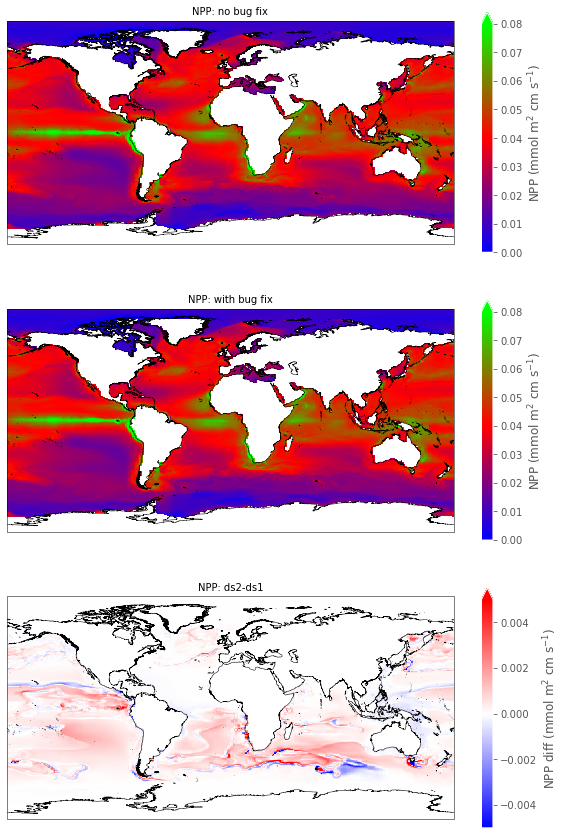

In [29]:
fig = plt.figure(figsize=(10,15))

#---- CESM panel
ax = fig.add_subplot(3,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('NPP: no bug fix', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds1_annmean.photoC_TOT_zint, cmap='brg',
                #norm=colors.LogNorm(),
                  vmin=0,vmax=0.08,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NPP (mmol m$^2$ cm s$^{-1}$)')

#---- CESM panel
ax = fig.add_subplot(3,1,2, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('NPP: with bug fix', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds2_annmean.photoC_TOT_zint, cmap='brg',
                #norm=colors.LogNorm(),
                  vmin=0,vmax=0.08,
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NPP (mmol m$^2$ cm s$^{-1}$)')

#---- CESM panel
ax = fig.add_subplot(3,1,3, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
ax.set_title('NPP: ds2-ds1', fontsize=10)
pc1=ax.pcolormesh(lons, lats, 
                 ds2_annmean.photoC_TOT_zint-ds1_annmean.photoC_TOT_zint, cmap='bwr',
                vmin=-0.005, vmax=0.005,
                #norm=colors.LogNorm(),
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc1, ax=ax,extend='max',label='NPP diff (mmol m$^2$ cm s$^{-1}$)')